# **Project Pipeline**

| **Steps**                                              | **Script files**                          |
|-----------------------------------------------------------|-------------------------------------------|
| 1) Read and pre-process data                              | pre_processing.py                         |
| 2) Feature engineering                                    | feature_engineering.py                    |
| 3) Train models                                           | model_training.py, <br>tree_model_training.py |
| 4) Predict on test_features <br>and write submission file | final_predict.py                          |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import scripts.pre_processing as pp
import scripts.feature_engineering as fe
import scripts.model_evaluation as me
from scripts.model_training import Model
import scripts.tree_model_training as tm
from scripts.model_evaluation import regression_evaluation
import scripts.final_predict as fp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit


## Pre-process data

In [31]:
# Read in data files 
train_features = pd.read_csv('./data/dengue_features_train.csv')
train_target = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/dengue_features_test.csv')

In [32]:
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=False)

# Run processing and split by city
train_iq = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=False)
train_sj = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=False)

# Run checks for missing values
assert train_iq.isnull().any().any() == False
assert train_sj.isnull().any().any() == False
print(f'train_iq shape: {train_iq.shape}') 
print(f'train_sj shape: {train_sj.shape}') 

train_iq shape: (518, 24)
train_sj shape: (928, 24)


In [33]:
Xy_iq = train_iq.copy()
Xy_sj = train_sj.copy()

In [34]:
# Run feature engineering 
periods=1

Xy_iq = fe.cyclical_encode_date(Xy_iq)
Xy_sj = fe.cyclical_encode_date(Xy_sj)
Xy_iq = fe.shift_features(Xy_iq, periods=1)
Xy_sj = fe.shift_features(Xy_sj, periods=1)
Xy_iq = fe.drop_date(Xy_iq)
Xy_sj = fe.drop_date(Xy_sj)

Text(0.5, 1.0, 'San Juan Variable Correlations')

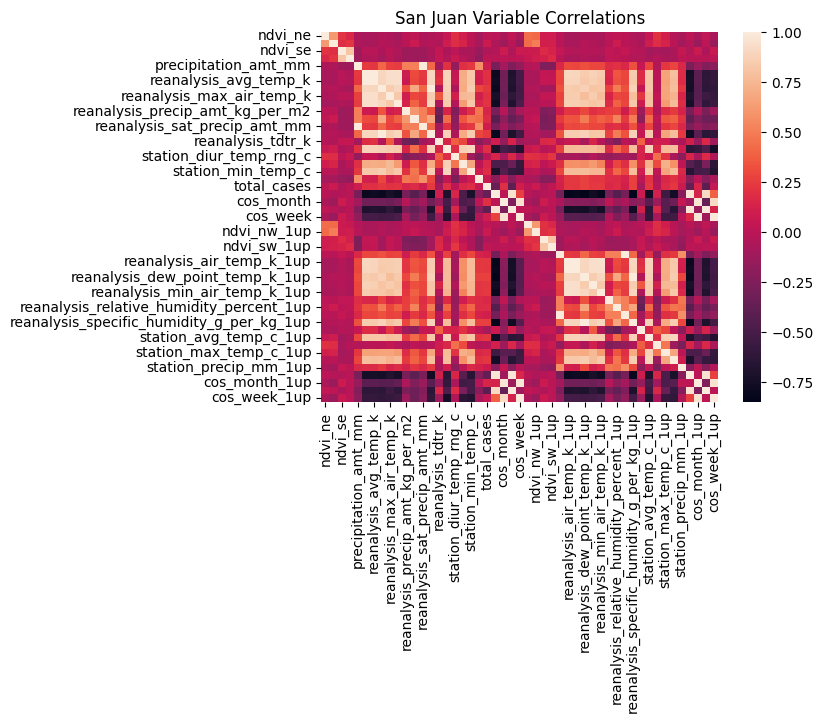

In [35]:
import seaborn as sns
sj_corr_heat = sns.heatmap(Xy_sj.corr())
plt.title('San Juan Variable Correlations')


In [37]:
(Xy_sj.total_cases
   .drop('total_cases', axis=1) # don't compare with myself
   .sort_values(ascending=False)
   .plot
   .barh())

ValueError: No axis named 1 for object type Series

In [38]:
# Split data into X and y
X_iq = Xy_iq.drop(labels=['total_cases'], axis=1)
y_iq = Xy_iq['total_cases']
X_sj = Xy_sj.drop(labels=['total_cases'], axis=1)
y_sj = Xy_sj['total_cases']
assert len(X_iq) == len(y_iq)

## Train model

In [39]:
# Baseline model predictions for Iquitos (Iq)
bl_pred_train = np.tile(np.mean(y_iq), len(y_iq))
bl_pred_test = np.tile(np.mean(y_iq), len(y_iq))
print('For Iquitos: ')
regression_evaluation(y_iq, y_iq, bl_pred_train, bl_pred_test)

# Baseline model predictions for San Jose (sj)
bl_pred_train = np.tile(np.mean(y_sj), len(y_sj))
bl_pred_test = np.tile(np.mean(y_sj), len(y_sj))
print('For San Jose: ')
regression_evaluation(y_sj, y_sj, bl_pred_train, bl_pred_test)

For Iquitos: 

    Evaluation metrics:
        RMSE train: 9.075651627174025
        RMSE test: 9.075651627174025
        MAE train: 6.223892490899363
        MAE test: 6.223892490899363 
    
For San Jose: 

    Evaluation metrics:
        RMSE train: 39.07577839160705
        RMSE test: 39.07577839160705
        MAE train: 24.207119741100325
        MAE test: 24.207119741100325 
    


(39.07577839160705, 39.07577839160705, 24.207119741100325, 24.207119741100325)

In [40]:
# XG boost model for iq
X, y = X_iq, y_iq
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_train,mae_test,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda
0,1,8.269286,0.177602,0.121401,5.671403,0.1,100,5,1.0,1.0,2
1,1,8.270862,0.009906,0.006985,5.683930,0.1,200,5,1.0,1.0,2
2,2,11.477965,0.622729,0.434704,6.797968,0.1,100,5,1.0,1.0,2
3,2,11.495313,0.113670,0.076066,6.806906,0.1,200,5,1.0,1.0,2


In [41]:
# XG boost model for sj
X, y = X_sj, y_sj
tm.xg_model(X, y)

,TSS iteration,rmse_test,rmse_train,mae_train,mae_test,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,reg_lambda
0,1,43.156531,1.438983,1.057598,25.761389,0.1,100,5,1.0,1.0,2
1,1,43.302428,0.257941,0.184401,25.904488,0.1,200,5,1.0,1.0,2
2,2,36.427232,5.459270,3.868991,28.608672,0.1,100,5,1.0,1.0,2
3,2,36.786371,1.625402,1.132557,28.984965,0.1,200,5,1.0,1.0,2


## Optimise models

## Predict on test data with chosen model and write file

Repeat the above transforms on the test set

In [42]:
# Code to run pipeline on dataset including test_features, and then take only test_features to run the final model
# Merge features and target data
data = pp.merge_data(train_features, train_target, test_features, inc_test=True)

# Run processing and split by city
Xy_iq_comb = pp.pre_process(data, 'iq', remove_anomalies=True, inc_test=True)
Xy_sj_comb = pp.pre_process(data, 'sj', remove_anomalies=True, inc_test=True)
assert Xy_iq_comb.isnull().any().any() == False
assert Xy_sj_comb.isnull().any().any() == False


# Run feature engineering 
Xy_iq_comb = fe.cyclical_encode_date(Xy_iq_comb)
Xy_sj_comb = fe.cyclical_encode_date(Xy_sj_comb)
Xy_iq_comb = fe.shift_features(Xy_iq_comb, periods=1)
Xy_sj_comb = fe.shift_features(Xy_sj_comb, periods=1)
Xy_iq_comb = fe.drop_date(Xy_iq_comb)
Xy_sj_comb = fe.drop_date(Xy_sj_comb)

# Split data into X and y
X_iq_comb = train_iq.drop(labels=['total_cases'], axis=1)
y_iq = train_iq.loc[train_iq['total_cases'] >= 0, train_iq.columns == 'total_cases']
y_test_iq = train_iq.loc[train_iq['total_cases'] < 0, train_iq.columns == 'total_cases']
X_sj_comb = train_sj.drop(labels=['total_cases'], axis=1)
y_sj = train_sj.loc[train_sj['total_cases'] >= 0, train_sj.columns == 'total_cases']
y_test_sj = train_sj.loc[train_sj['total_cases'] < 0, train_sj.columns == 'total_cases']





KeyError: "['total_cases_1up'] not found in axis"

In [20]:
print(y_test_iq.shape)
print(y_test_sj.shape)
print(X_iq_comb.shape)
print(X_sj_comb.shape)


(156, 23)
(260, 23)
(673, 48)
(1187, 48)


In [18]:
X_test_iq = train_iq.iloc[y_test_iq.shape[], :]


y_test_iq.shape



(156, 23)

In [ ]:

# Split into to final test_features DataFrames
test_iq = train_iq.loc[train_iq['total_cases'] < 0, train_iq.columns != 'total_cases']
X_iq = train_iq.loc[train_iq['total_cases'] >= 0, train_iq.columns != 'total_cases']
y_iq = train_iq.loc[train_iq['total_cases'] >= 0, train_iq.columns == 'total_cases']
test_sj = train_sj.loc[train_sj['total_cases'] 
                       < 0, train_sj.columns != 'total_cases']
X_sj = train_sj.loc[train_sj['total_cases'] >= 0, train_sj.columns != 'total_cases']
y_sj = train_sj.loc[train_sj['total_cases'] >= 0, train_sj.columns == 'total_cases']
assert len(X_iq) == len(y_iq)
assert len(X_sj) == len(y_sj)
assert test_iq.shape[1] == X_iq.shape[1]
assert test_sj.shape[1] == X_sj.shape[1]

In [11]:
# Select data and chosen model and hyperparameters for final prediction

params = dict(learning_rate=0.1,
        n_estimators=150,
        max_depth=5,
        subsample=1.0,
        colsample_bytree=1.0,
        reg_lambda=2)

# Iquitos, iq
final_test_iq = test_iq
X_train_iq = X_iq
y_train_iq = y_iq
model_iq = 'XGBRegressor'
params_iq = params

# San Jose, sj
final_test_sj = test_sj
X_train_sj = X_sj
y_train_sj = y_sj
model_sj = 'XGBRegressor'
params_sj = params

In [12]:
test_sj.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,station_avg_temp_c_1up,station_diur_temp_rng_c_1up,station_max_temp_c_1up,station_min_temp_c_1up,station_precip_mm_1up,total_cases_1up,sin_month_1up,cos_month_1up,sin_week_1up,cos_week_1up
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,...,27.042857,7.514286,31.7,23.3,0.3,5.0,0.866025,-0.500000,0.902798,-0.430065
2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,...,26.528571,7.057143,33.3,21.7,75.2,-1.0,0.866025,-0.500000,0.845596,-0.533823
2008-05-13,-0.0015,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,...,26.071429,5.557143,30.0,22.2,34.3,-1.0,0.500000,-0.866025,0.776524,-0.630088
2008-05-20,-0.0015,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,...,27.928571,7.785714,32.8,22.8,3.0,-1.0,0.500000,-0.866025,0.696551,-0.717507
2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,...,28.057143,6.271429,33.3,24.4,0.3,-1.0,0.500000,-0.866025,0.6068,-0.794854


In [13]:
import datetime as dt

test_sj = test_sj.reset_index()
test_sj['weekofyear'] = test_sj['week_start_date'].dt.strftime('%W') 
test_sj.head()

,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,station_diur_temp_rng_c_1up,station_max_temp_c_1up,station_min_temp_c_1up,station_precip_mm_1up,total_cases_1up,sin_month_1up,cos_month_1up,sin_week_1up,cos_week_1up,weekofyear
0,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,7.514286,31.7,23.3,0.3,5.0,0.866025,-0.500000,0.902798,-0.430065,17
1,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,7.057143,33.3,21.7,75.2,-1.0,0.866025,-0.500000,0.845596,-0.533823,18
2,2008-05-13,-0.0015,-0.012400,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,5.557143,30.0,22.2,34.3,-1.0,0.500000,-0.866025,0.776524,-0.630088,19
3,2008-05-20,-0.0015,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,7.785714,32.8,22.8,3.0,-1.0,0.500000,-0.866025,0.696551,-0.717507,20
4,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,6.271429,33.3,24.4,0.3,-1.0,0.500000,-0.866025,0.6068,-0.794854,21


In [ ]:
# Perform final predictions and reformat for submission
final_iq = fp.final_predict(final_test_iq, X_train_iq, y_train_iq, 
              city='iq', model=model_iq, params=params_iq)
final_sj = fp.final_predict(final_test_sj, X_train_sj, y_train_sj, 
              city='sj', model=model_sj, params=params_sj)

# Merge the two cities into one DataFrame and write to new csv file 
final_comb = fp.write_submission(final_iq, final_sj) 

# 